In [1]:
import random
import time
import os
import shutil
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models
from torchvision.transforms import transforms

from PIL import Image
import imagehash

from tqdm.notebook import tqdm

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"

print(f"Using device {device}")

if device == "cpu":
    print(f"It is highly recommended to use a GPU! This is likely to run extremely slowly otherwise.")

Using device cuda:0


# Code Acknowledgements
I have used multiple open source repositories as references for my implementation:

* CycleGAN: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix by Jun-Yan Zhu, Taesung Park, Phillip Isola, and Alexei A. Efros
* RecycleGAN: https://github.com/aayushbansal/Recycle-GAN/ by Aayush Bansal, Shugao Ma, Deva Ramanan, and Yaser Sheikh
* GAN Training Tips: https://github.com/soumith/ganhacks by Soumith Chintala, Emily Denton, Martin Arjovsky, and Michael Mathieu
* Transpose Convolution Replacements: https://gist.github.com/bearpelican/a87a6140661ffbc9b97409a12a1cf45b by Andrew Shaw
* Practicals on Blackboard from the Advanced Computer Vision course materials 

My implementation is my own work but I have used these resources, along with the papers cited in my report, to guide my code.

# 1: Human Feature Analysis

In [3]:
from skeletal_pose import PoseKeypoints

General setup instructions:

* Please place the original data into a folder called 'original_data' in the same directory as this notebook
* Please ensure ffmpeg is available on your system

## 1.1: Human Patch Extraction

The process I follow to extract the human patches is as follows:

1. Extract the frames from the training videos using ffmpeg
2. Use a pre-trained MaskR-CNN model to segment and extract the human patches
3. Save the human patches for future processing

Firstly, I use ffmpeg to extract all frames from the videos and store them for later processing:

In [4]:
%%bash
./frame_extraction.sh ./original_data

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

Next, I use a pre-trained MaskR-CNN model to extract the human patches.
This part is heavily inspired by the practical 'Semantic Segmentation Mask R-CNN.ipynb' on Blackboard.

In [5]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")
maskrcnn.to(device).eval()
;

''

In [6]:
# The 91 COCO class names, directly from Semantic Segmentation Mask R-CNN.ipynb
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [7]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

def batch_loader(input_directory, output_directory, batch_size):
    # Get all files in the directory that are frames
    file_names = [file_name for file_name in os.listdir(input_directory) if file_name.endswith(".jpg")]
    
    for i in tqdm(range(len(file_names) // batch_size + 1)):
        selected = []
        start_idx = batch_size * i
        limit_idx = batch_size * (i + 1)
        
        # Get the images to put through the model
        if limit_idx > len(file_names):
            selected = file_names[start_idx:]
        else:
            selected = file_names[start_idx:limit_idx]
            
        if len(selected) == 0:
            break
        
        output_files = []
        raw_frames = []
        usable_frames = []
        
        for file_name in selected:
            # Pre-determine the save location and load the frame with RGB
            output_files.append(f"{output_directory}/Segmented_{file_name.split('.')[0]}")
            input_file = f"{input_directory}/{file_name}"
            raw_frame = cv2.imread(input_file, cv2.IMREAD_COLOR)
            raw_frames.append(raw_frame)
            
            usable_frame = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB)
            usable_frame = tensor_transform(usable_frame)
            usable_frames.append(usable_frame)
        
        # Return a tensor to use with the model and additional info for cropping and saving
        stacked_frames = torch.stack(usable_frames).to(device)
        yield stacked_frames, raw_frames, output_files

In [8]:
def process_maskrcnn_output(maskrcnn_output, original_frame, save_loc, threshold):
    # Get the relevant model output on to the CPU in a usable format
    scores = output["scores"].detach().cpu().numpy()
    boxes = output["boxes"].detach().cpu().numpy().astype(int)
    label_indices = output["labels"].detach().cpu()
    
    # Process each entry found by the model
    for i, (confidence, box, label_idx) in enumerate(zip(scores, boxes, label_indices)):
        label = coco_names[label_idx.item()]
        
        if label != "person":
            continue
        
        # The confidences are sorted high to low so stop once we're below the threshold
        if confidence < threshold:
            break
          
        # Crop and save the patch using its bounding box
        x_0, y_0, x_1, y_1 = box
        patch = original_frame.copy()[y_0:y_1, x_0:x_1]
        cv2.imwrite(f"{save_loc}_{i}.jpg", patch)

In [9]:
# If everything is setup correctly and the frames have been extracted these settings should be fine
base_folders = ["Train/Game", "Train/Movie"]
base_frame_folder = "./extracted_data/frames"
base_output_folder = "./extracted_data/unclassified_human_patches"

batch_size = 4
threshold = 0.965

In [ ]:
# Process each folder and every frame in them
# Takes a few hours to run
for base_folder in base_folders:
    in_directory = f"{base_frame_folder}/{base_folder}"
    out_directory = f"{base_output_folder}/{base_folder}"
    
    os.makedirs(out_directory)
    
    print(f"{in_directory} -> {out_directory}")
    
    batch_generator = batch_loader(in_directory, out_directory, batch_size)

    for i, (batch, raw_frames, output_files) in enumerate(batch_generator):
        with torch.no_grad():
            outputs = maskrcnn(batch)

        for output, frame, output_file in zip(outputs, raw_frames, output_files):
            process_maskrcnn_output(output, frame, output_file, threshold)

In testing, this gave:

* 18,454 human patches for the movie clips
* 37,530 human patches for the game clips 

I now sample 50 random images from each domain

In [11]:
base_submission_folder = "./data_for_submission/1_1_sampled_human_patches"
sample_count = 50

In [12]:
for base_folder in base_folders:
    patch_directory = f"{base_output_folder}/{base_folder}"
    sampled_directory = f"{base_submission_folder}/{base_folder}"
    
    os.makedirs(sampled_directory) 
    
    print(f"{patch_directory} -> {sampled_directory}")
    
    file_names = [file_name for file_name in os.listdir(patch_directory) if file_name.endswith(".jpg")]
    sampled_file_names = random.sample(file_names, k=sample_count)
    
    for sampled in sampled_file_names:
        shutil.copy(f"{patch_directory}/{sampled}", sampled_directory)

./extracted_data/unclassified_human_patches/Train/Game -> ./data_for_submission/1_1_sampled_human_patches/Train/Game
./extracted_data/unclassified_human_patches/Train/Movie -> ./data_for_submission/1_1_sampled_human_patches/Train/Movie


## 1.2: Classification

Using the human patches from the previous task, I use the following process to classify them according to pose:
1. Use OpenPose to extract the pose keypoints from each human patch
2. Load the extracted pose into Python and analyse the data to determine the pose based on joint visibility
3. To determine if they are standing or sitting I compute the angle between the hips and knees if they are visible
4. Save the images into folders based on their classified pose

Firstly, I use OpenPose to extract the pose. Depending on your install of OpenPose you may need to adjust the command slightly below to point to the OpenPose executable. I generated normalised keypoints so that image scale is irrelevant for determining the pose and limit the resolution and disable the display to work within my GPU resource constraints. Depending on your operating system use the %%cmd cell for Windows and the %%bash cell for Unix. The Unix one is untested as I am using Windows to run this but something along those lines should work if you want to run it! (May need to play around with directories based on OpenPose installation)

In [17]:
%%cmd
mkdir .\extracted_data\human_poses\Train\Game
mkdir .\extracted_data\human_poses\Train\Movie
cd .\openpose
.\bin\OpenPoseDemo.exe --image_dir ..\extracted_data\unclassified_human_patches\Train\Game --write_json ..\extracted_data\human_poses\Train\Game --keypoint_scale 3 --net_resolution "656x368" --display 0 --render_pose 0
.\bin\OpenPoseDemo.exe --image_dir ..\extracted_data\unclassified_human_patches\Train\Movie --write_json ..\extracted_data\human_poses\Train\Movie --keypoint_scale 3 --net_resolution "656x368" --display 0 --render_pose 0

Microsoft Windows [Version 10.0.19045.2728]
(c) Microsoft Corporation. All rights reserved.

F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test>mkdir .\extracted_data\human_poses\Train\Game

F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test>mkdir .\extracted_data\human_poses\Train\Movie


A subdirectory or file .\extracted_data\human_poses\Train\Game already exists.
A subdirectory or file .\extracted_data\human_poses\Train\Movie already exists.



F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test>cd .\openpose

F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test\openpose>.\bin\OpenPoseDemo.exe --image_dir ..\extracted_data\unclassified_human_patches\Train\Game --write_json ..\extracted_data\human_poses\Train\Game --keypoint_scale 3 --net_resolution "656x368" --display 0 --render_pose 0
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.

F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test\openpose>.\bin\OpenPoseDemo.exe --image_dir ..\extracted_data\unclassified_human_patches\Train\Movie --write_json ..\extracted_data\human_poses\Train\Movie --keypoint_scale 3 --net_resolution "656x368" --display 0 --render_pose 0
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1

In [ ]:
%%bash
mkdir -p ./extracted_data/human_poses/Train/Game
./openpose/build/examples/openpose/openpose.bin --image_dir ./extracted_data/unclassified_human_patches/Train/Game --write_json ./extracted_data/human_poses/Train/Game --keypoint_scale 3 --net_resolution "656x368" --display 0 --render_pose 0
mkdir -p ./extracted_data/human_poses/Train/Movie
./openpose/build/examples/openpose/openpose.bin --image_dir ./extracted_data/unclassified_human_patches/Train/Movie --write_json ./extracted_data/human_poses/Train/Movie --keypoint_scale 3 --net_resolution "656x368" --display 0 --render_pose 0

Now that I have the extracted pose data saved as .json files in a one-to-one mapping with each human patch (although there may be multiple humans detected by the pose detector!), I process these using Python. Before this I need to define what I count as each class. In connection with Q1.3 I consider those that are facing away to be in the class 'Other' regardless of all other attributes. I group the joints and measure the visibility of each group, the groups are:

* Head: Nose, Left Eye, Left Ear, Right Eye, Right Eye
* Torso and Arms: Neck, Left Shoulder, Left Elbow, Left Wrist, Right Shoulder, Right Elbow, Right Wrist
* Hips: Mid Hip, Left Hip, Right Hip
* Legs: Left Knee, Left Ankle, Right Knee, Right Ankle
* Feet: Left Ankle, Left Heel, Left Big Toe, Left Small Toe, Right Ankle, Right Heel, Right Big Toe, Right Small Toe

Then to classify by pose:

* Head Only: At least 60% of the Head group visible, less than 45% of the Torso and Arms group visible and none of the Hips, Legs or Feet groups visible
* Half Body: At least 40% of the Head group visible, at least 50% of the Torso and Arms group visible, any amount of Hips, and none of the Legs or Feet groups visible
* Full Body: At least 40% of the Head group visible, at least 70% of the Torso and Arms group visible, at least 50% of the Hips and Legs visible, and any amount of Feet visible

Finally, to classify sitting and standing I measure the angle between the knees and hips. If this is less than 50 degrees they are sitting otherwise they are standing.

In [18]:
base_folders = ["Train/Movie", "Train/Game"]
base_patch_directory = "./extracted_data/unclassified_human_patches"
base_pose_directory = "./extracted_data/human_poses"
base_classification_directory = "./extracted_data/classified_human_patches"
base_sample_directory = "./extracted_data/human_patches_validation_set/raw"
base_sample_classified_directory = "./extracted_data/human_patches_validation_set/hand_classified"

sample_count = 150

classes = ["Full Body Sitting", "Full Body Standing", "Half Body", "Head Only", "Other"]
show_skeleton = False
enforce_facing = True

Prior to classifying them, I sample 150 patches from each domain to classify by hand to evaluate the performance of the pose classification process. I put the classified files in the following directory: ./extracted_data/human_patches_validation_set/{base_folder}/{class_name}

In [19]:
for base_folder in base_folders:
    patch_directory = f"{base_patch_directory}/{base_folder}"
    sampled_directory = f"{base_sample_directory}/{base_folder}"
    
    os.makedirs(sampled_directory) 
    
    print(f"{patch_directory} -> {sampled_directory}")
    
    file_names = [file_name for file_name in os.listdir(patch_directory) if file_name.endswith(".jpg")]
    sampled_file_names = random.sample(file_names, k=sample_count)
    
    for sampled in sampled_file_names:
        shutil.copy(f"{patch_directory}/{sampled}", sampled_directory)

./extracted_data/unclassified_human_patches/Train/Movie -> ./extracted_data/human_patches_validation_set/raw/Train/Movie
./extracted_data/unclassified_human_patches/Train/Game -> ./extracted_data/human_patches_validation_set/raw/Train/Game


In [ ]:
for base_folder in base_folders:
    patch_directory = f"{base_patch_directory}/{base_folder}"
    pose_directory = f"{base_pose_directory}/{base_folder}"
    output_directory = f"{base_classification_directory}/{base_folder}"
    
    for class_name in classes:
        os.makedirs(f"{output_directory}/{class_name}")
    
    file_names = [''.join(file_name.split(".")[:-1]) for file_name in os.listdir(patch_directory) if file_name.endswith(".jpg")]
    
    for file_name in tqdm(file_names):
        patch_loc = f"{patch_directory}/{file_name}.jpg"
        keypoints_loc = f"{pose_directory}/{file_name}_keypoints.json"
        
        with open(keypoints_loc, "r") as fp:
            raw_data = json.load(fp)

        if len(raw_data["people"]) != 1:
            continue
        
        kps = raw_data["people"][0]["pose_keypoints_2d"]
        pose = PoseKeypoints.load_keypoints(kps)
        
        classification = pose.classify(enforce_facing=enforce_facing)
        save_loc = f"{output_directory}/{classification}/{file_name}.jpg"
        
        patch = cv2.imread(patch_loc)
    
        if show_skeleton:
            patch = pose.overlay_pose(patch)
        
        cv2.imwrite(save_loc, patch)

I now evaluate the results using the hand classified set

In [21]:
for base_folder in base_folders:
    classification_data = {}
    hand_classified_folder = f"{base_sample_classified_directory}/{base_folder}"
    pred_classified_folder = f"{base_classification_directory}/{base_folder}"
    
    for class_name in classes:
        for file_name in os.listdir(f"{hand_classified_folder}/{class_name}"):
            classification_data[file_name] = {"ground_truth": class_name, "predicted": None}
    
    for class_name in classes:
        classified_files = os.listdir(f"{pred_classified_folder}/{class_name}")
        
        for file_name in classification_data.keys():
            if file_name in classified_files:
                classification_data[file_name]["predicted"] = class_name
                
    correct = 0
    
    classification_data_rows = [{"file": key, **value} for key, value in classification_data.items() if value["predicted"] is not None]
    df = pd.DataFrame(classification_data_rows)
    
    df["match"] = df.apply(lambda row: row["ground_truth"] == row["predicted"], axis=1)
    
    print(f"{base_folder} Accuracy:", df["match"].sum() / len(df))
    

Train/Movie Accuracy: 0.7843137254901961
Train/Game Accuracy: 0.7474747474747475


I now sample 10 images from each class per domain:

In [22]:
base_submission_folder = "./data_for_submission/1_2_sampled_pose_classified"
sample_count = 10

In [23]:
for base_folder in base_folders:
    for class_name in classes:
        sampled_directory = f"{base_submission_folder}/{base_folder}/{class_name}"
        os.makedirs(sampled_directory)
        
        class_folder = f"{base_classification_directory}/{base_folder}/{class_name}"
        print(f"{class_folder} -> {sampled_directory}")
        
        file_names = [file_name for file_name in os.listdir(class_folder) if file_name.endswith(".jpg")]
        sampled_file_names = random.sample(file_names, k=min(sample_count, len(file_names)))
        
        for sampled in sampled_file_names:
            shutil.copy(f"{class_folder}/{sampled}", sampled_directory)
    

./extracted_data/classified_human_patches/Train/Movie/Full Body Sitting -> ./data_for_submission/1_2_sampled_pose_classified/Train/Movie/Full Body Sitting
./extracted_data/classified_human_patches/Train/Movie/Full Body Standing -> ./data_for_submission/1_2_sampled_pose_classified/Train/Movie/Full Body Standing
./extracted_data/classified_human_patches/Train/Movie/Half Body -> ./data_for_submission/1_2_sampled_pose_classified/Train/Movie/Half Body
./extracted_data/classified_human_patches/Train/Movie/Head Only -> ./data_for_submission/1_2_sampled_pose_classified/Train/Movie/Head Only
./extracted_data/classified_human_patches/Train/Movie/Other -> ./data_for_submission/1_2_sampled_pose_classified/Train/Movie/Other
./extracted_data/classified_human_patches/Train/Game/Full Body Sitting -> ./data_for_submission/1_2_sampled_pose_classified/Train/Game/Full Body Sitting
./extracted_data/classified_human_patches/Train/Game/Full Body Standing -> ./data_for_submission/1_2_sampled_pose_classified/T

## 1.3: Training Data Selection

Now that I have classified the human patches according to pose, I need to select the most appropriate data for training the model. I will use CycleGAN initially as such I need approximately 1200 images from both domains to form a quality dataset. This needs to be diverse (i.e. not just similar patches a couple of frames apart) and representative of the data. To achieve this I group human patches into sequences to reduce oversampling of extremely similar patches which will degrade the model performance.

In [24]:
def group_similar_images(ordered_dir, cutoff, window):
    image_locs = [f"{ordered_dir}/{file_name}" for file_name in os.listdir(ordered_dir) if file_name.endswith(".jpg")]
    groups = [[image_locs[0]]]
    
    for image_loc in tqdm(image_locs):
        img_hash = imagehash.average_hash(Image.open(image_loc))
        
        closest_group_idx = -1
        closest_group_diff = 65
        
        for offset, group in enumerate(groups[-window:][::-1]):
            group_idx = len(groups) - offset - 1
            last_hash = imagehash.average_hash(Image.open(group[-1]))
            diff = img_hash - last_hash
            
            if diff < closest_group_diff:
                closest_group_idx = group_idx
                closest_group_diff = diff
        
        if closest_group_diff <= cutoff:
            groups[closest_group_idx].append(image_loc)
        else:
            groups.append([image_loc])
    
    return groups

In [25]:
def group_classes(base_directory, classes, cutoff, window):
    groups = []
    
    for class_name in classes:
        pose_directory = f"{base_directory}/{class_name}"
        groups += group_similar_images(pose_directory, cutoff, window)
    
    return groups

I discard all images from the 'Other' category as I determine that these will likely not be of use to the model for training.

In [26]:
classes = ["Full Body Sitting", "Full Body Standing", "Half Body", "Head Only"]
base_pose_directory = "./extracted_data/classified_human_patches"
cutoff = 8
window = 5

In [27]:
game_groups = group_classes(f"{base_pose_directory}/Train/Game", classes, cutoff, window) 
movie_groups = group_classes(f"{base_pose_directory}/Train/Movie", classes, cutoff, window)

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/4011 [00:00<?, ?it/s]

  0%|          | 0/9336 [00:00<?, ?it/s]

  0%|          | 0/3285 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1157 [00:00<?, ?it/s]

  0%|          | 0/5331 [00:00<?, ?it/s]

  0%|          | 0/3661 [00:00<?, ?it/s]

Now I sample from these sequences of images. I also discard images that are too small, as I will training on 128x128 images for CycleGAN I discard all images that are smaller than 64x64 pixels as they will be too poor quality to be useful when resized to 128x128.

In [28]:
target_test_count = 250
target_train_count = 1200
output_size = 128
min_size = 64
sequence_proportion = 0.05

train_output_directory = lambda base: f"./extracted_data/cyclegan_training_data/{base}/Train"
test_output_directory = lambda base: f"./extracted_data/cyclegan_training_data/{base}/Test"

In [29]:
def create_train_test_split(groups, train_dir, test_dir, train_target, test_target, output_size, min_size, sequence_proportion):
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    
    for group_no, group in enumerate(tqdm(groups)):
        selected_patches = random.sample(range(len(group)), k=max(1, int(sequence_proportion * len(group))))
        
        for i in selected_patches:
            patch = Image.open(group[i])
            
            if patch.width < min_size or patch.height < min_size:
                continue
                
            patch = patch.resize((output_size, output_size))
            patch.save(f"{train_dir}/{group_no:05d}_{i:05d}.jpg")
    
    valid_train_files = [file_name for file_name in os.listdir(train_dir) if file_name.endswith(".jpg")]
    
    if len(valid_train_files) <= train_target:
        print(f"Only found {len(valid_train_files)} valid files, not able to produce a test set")
        return
    
    available_for_test = min(len(valid_train_files) - train_target, test_target)
    selected_for_test = random.sample(valid_train_files, k=available_for_test)
    
    for file_name in selected_for_test:
        os.rename(f"{train_dir}/{file_name}", f"{test_dir}/{file_name}")
    
    print("Moved", len(selected_for_test), "files to test set")
    
    valid_train_files = [file_name for file_name in os.listdir(train_dir) if file_name.endswith(".jpg")]
    
    if len(valid_train_files) > train_target:
        selected_for_delete = random.sample(valid_train_files, k=len(valid_train_files) - train_target)
    
        for file_name in selected_for_delete:
            os.remove(f"{train_dir}/{file_name}")

        print("Deleted", len(selected_for_delete), "files from the train set")
    
    print("Train Size:", len([file_name for file_name in os.listdir(train_dir) if file_name.endswith(".jpg")]))
    print("Test Size:", len([file_name for file_name in os.listdir(test_dir) if file_name.endswith(".jpg")]))

In [30]:
create_train_test_split(game_groups, train_output_directory("Game"), test_output_directory("Game"), target_train_count, target_test_count, output_size, min_size, sequence_proportion)

  0%|          | 0/1302 [00:00<?, ?it/s]

Moved 250 files to test set
Deleted 181 files from the train set
Train Size: 1200
Test Size: 250


In [31]:
create_train_test_split(movie_groups, train_output_directory("Movie"), test_output_directory("Movie"), target_train_count, target_test_count, output_size, min_size, sequence_proportion)

  0%|          | 0/1328 [00:00<?, ?it/s]

Moved 104 files to test set
Train Size: 1200
Test Size: 104


Now I sample 50 random images from each training dataset for submission

In [32]:
base_submission_folder = "./data_for_submission/1_3_sampled_training_data"
sample_count = 50

In [33]:
for base_folder in ["Game", "Movie"]:
    train_directory = train_output_directory(base_folder)
    sampled_directory = f"{base_submission_folder}/{base_folder}"
    
    os.makedirs(sampled_directory) 
    
    print(f"{train_directory} -> {sampled_directory}")
    
    file_names = [file_name for file_name in os.listdir(train_directory) if file_name.endswith(".jpg")]
    sampled_file_names = random.sample(file_names, k=sample_count)
    
    for sampled in sampled_file_names:
        shutil.copy(f"{train_directory}/{sampled}", sampled_directory)

./extracted_data/cyclegan_training_data/Game/Train -> ./data_for_submission/1_3_sampled_training_data/Game
./extracted_data/cyclegan_training_data/Movie/Train -> ./data_for_submission/1_3_sampled_training_data/Movie


# Real-world Application

In [34]:
from joint_dataset import JointDomainImageDataset, JointDomainTripletDataset
from generator_model import Generator
from cycle_gan import CycleGAN
from recycle_gan import RecycleGAN
from visdom_utils import MultiLinePlot
from image_utils import revert_normalisation

## 2.1: Image Model Deployment

### Data Loading

In [37]:
using_google_gpus = False

train_X_loc = "./extracted_data/cyclegan_training_data/Game/Train" 
test_X_loc = "./extracted_data/cyclegan_training_data/Game/Test" 

train_Y_loc = "./extracted_data/cyclegan_training_data/Movie/Train"
test_Y_loc = "./extracted_data/cyclegan_training_data/Movie/Test"

run_data_directory = "./runs"

In [39]:
if using_google_gpus:
    from google.colab import drive
    drive.mount("/content/drive")
    vis = None
else:
    import visdom
    vis = visdom.Visdom()

Setting up a new session...


In [40]:
%cd drive/MyDrive/cyclegan

[WinError 3] The system cannot find the path specified: 'drive/MyDrive/cyclegan'
F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test


In [41]:
train_dataset = JointDomainImageDataset(train_X_loc, train_Y_loc, train=True, img_size=128)
test_dataset = JointDomainImageDataset(test_X_loc, test_Y_loc, train=False, img_size=128)

In [42]:
test_xs = []
test_ys = []

for i in random.sample(range(0, len(test_dataset)), 16):
    x, y = test_dataset[i]
    test_xs.append(x)
    test_ys.append(y)

test_xs = torch.stack(test_xs)
test_ys = torch.stack(test_ys)

In [43]:
if vis is not None:
    vis.images(torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in test_xs]), nrow=4, opts={"title": "X_test originals"})
    vis.images(torch.stack([revert_normalisation(y).permute(2, 0, 1) for y in test_ys]), nrow=4, opts={"title": "Y_test originals"})

In [44]:
test_img = test_dataset[random.randint(0, len(test_dataset))][0]

In [45]:
print(test_img.min(), test_img.max())

tensor(-0.9608) tensor(0.8431)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


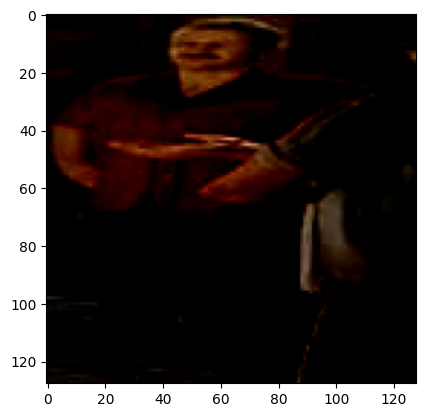

In [46]:
plt.imshow(test_img.permute(1, 2, 0))

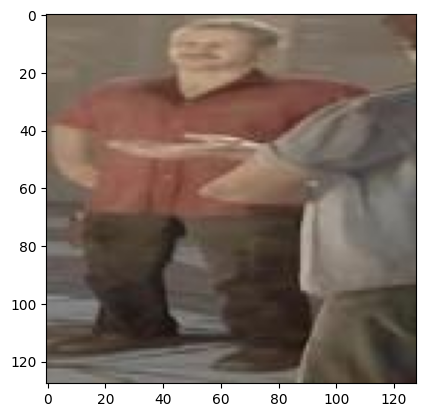

In [47]:
plt.imshow(revert_normalisation(test_img))

### Training

In [48]:
batch_size = 1
epochs = 100
lambda_weight = 10
lambda_idt_X = 0.5
lambda_idt_Y = 0.5

blocks = 6
upsample_strategy = ["upsample", "conv_transpose", "pixel_shuffle"][0]
pool_size = 50
opt_scheduler_type = "linear_decay_with_warmup"

checkpoint_instance_dir = None
checkpoint_epoch_dir = None

In [49]:
dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
)

In [50]:
if checkpoint_instance_dir is not None and checkpoint_epoch_dir is not None:
    cyclegan = CycleGAN.load(f"{run_data_directory}/{checkpoint_instance_dir}", f"{checkpoint_epoch_dir}", device, blocks)
else:
    cyclegan = CycleGAN(blocks, upsample_strategy, device, pool_size, opt_scheduler_type, epochs)

Initialised weights


In [51]:
with open(f"{cyclegan.save_folder}/info_{checkpoint_epoch_dir}.json", "w+") as fp:
    json.dump({
        "block_count": cyclegan.resnet_block_count,
        "upsample_strategy": upsample_strategy,
        "pool_size": pool_size,
        "opt_scheduler_type": opt_scheduler_type,
        "data_folders": {
            "train_X": train_X_loc,
            "test_X": test_X_loc,
            "train_Y": train_Y_loc,
            "test_Y": test_Y_loc
        },
        "batch_size": batch_size,
        "max_epochs": epochs,
        "start_epoch": cyclegan.start_epoch,
        "lambda_weight": lambda_weight,
        "lambda_idt_X": lambda_idt_X,
        "lambda_idt_Y": lambda_idt_Y,
        "checkpoint": {
            "instance": checkpoint_instance_dir,
            "epoch": checkpoint_epoch_dir
        }
    }, fp, indent=2)

In [52]:
# Could also enable random flipping
def generate_noisy_labels(shape, real, device):
    # Randomly generated between 0 and 1
    labels = torch.rand(shape, device=device)
    
    if real:
        # Now they are between 0.7 and 1.1
        labels = (2 * labels / 5) + 0.7
    else:
        # Now they are between 0 and 0.3
        labels = (labels * 3) / 10
    
    return labels

In [53]:
def get_discriminator_loss(real, fake, pool, discriminator, loss_func):
    # Discriminator should give (1) for a real image and (0) for a fake
    real_pred = discriminator(real)
    real_loss = loss_func(real_pred, generate_noisy_labels(real_pred.shape, True, device)) # Should dampen?
    
    # We draw from the history buffer
    pool_fake = pool.randomise_existing_batch(fake)
    fake_pred = discriminator(pool_fake)
    # Fake images should not fool the discriminator
    fake_loss = loss_func(fake_pred.detach(), generate_noisy_labels(fake_pred.shape, False, device))
    
    avg_loss = (real_loss + fake_loss) * 0.5
    return avg_loss

In [54]:
if cyclegan.start_epoch != 0:
    print(f"Resuming training from epoch {cyclegan.start_epoch + 1}")
else:
    print("Starting training from scratch")

if vis is not None:
    loss_plot = MultiLinePlot(vis, "Losses", "Epoch", "Loss")

for epoch in range(cyclegan.start_epoch + 1, epochs + 1):
    cyclegan.G.train()
    cyclegan.F.train()
    
    cyclegan.D_X.train()
    cyclegan.D_Y.train()

    batch_start_time = time.time()
    epoch_start_time = time.time()
    
    cum_loss_idt_x = 0
    cum_loss_idt_y = 0
    cum_G_fool_loss = 0
    cum_F_fool_loss = 0
    cum_cycled_x_loss = 0
    cum_cycled_y_loss = 0
    cum_D_X_loss = 0
    cum_D_Y_loss = 0
    
    ep_loss_idt_x = 0
    ep_loss_idt_y = 0
    ep_G_fool_loss = 0
    ep_F_fool_loss = 0
    ep_cycled_x_loss = 0
    ep_cycled_y_loss = 0
    ep_D_X_loss = 0
    ep_D_Y_loss = 0
    
    for batch_no, (x, y) in enumerate(dataloader):
        # Load the sequence of frames to the GPU
        x = x.to(device)
        y = y.to(device)
        
        # Firstly, generate fake images in domain Y using the x_t images
        fake_y = cyclegan.G(x)
        
        # Then generate the fake images in domain X using the y_t images
        fake_x = cyclegan.F(y)
        
        ### GENERATOR TRAINING
        
        # Freeze discriminator weights
        for param in cyclegan.D_X.parameters():
            param.requires_grad = False

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = False
        
        # Zero the gradients for the generators and predictors
        cyclegan.G_opt.zero_grad()
        cyclegan.F_opt.zero_grad()
        
        # Calculate the identity loss, this tries to enforce that G(y) = I(y) = y i.e. the identity
        idt_x = cyclegan.F(x)
        loss_idt_x = cyclegan.identity_loss(idt_x, x)
        
        idt_y = cyclegan.G(y)
        loss_idt_y = cyclegan.identity_loss(idt_y, y)
        
        # Now we try and fool the discriminators
        # D_X tries to tell if an image is from X (1) or from F(Y) (0) so it takes input fake_x_t
        # D_X is supposed to be 1 if the image is from X but here we are trying to get it to be 1 if it is from G(X) -> Y which is incorrect
        G_fool = cyclegan.D_Y(fake_y) 
        # We want to tell if fake_y_0 has fooled D_X, so we measure how far from the output 1 it is 
        G_fool_loss = cyclegan.gan_loss(G_fool, generate_noisy_labels(G_fool.shape, True, device))
        
        # D_Y tries to tell if an image is from Y (1) or from G(X) (0) so it takes input fake_y_t
        F_fool = cyclegan.D_X(fake_x)
        # We want to tell if fake_x_0 has fooled D_Y, so we measure how far from the output 1 it is 
        F_fool_loss = cyclegan.gan_loss(F_fool, generate_noisy_labels(F_fool.shape, True, device))
        
        # Now do the cycle loss
        cycled_x = cyclegan.F(fake_y)
        cycled_loss_x = cyclegan.cycle_loss(cycled_x, x)
        
        cycled_y = cyclegan.G(fake_x)
        cycled_loss_y = cyclegan.cycle_loss(cycled_y, y)
        
        # Backpropagate and step the gradients
        generator_loss = G_fool_loss + F_fool_loss + lambda_weight * (cycled_loss_x + cycled_loss_y + lambda_idt_X * loss_idt_x + lambda_idt_Y * loss_idt_y)
        generator_loss.backward()
        
        cyclegan.G_opt.step()
        cyclegan.F_opt.step()
        
        ### DISCRIMINATOR TRAINING
        # Unfreeze discriminator weights
        for param in cyclegan.D_X.parameters():
            param.requires_grad = True

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = True
        
        # Zero the gradients
        cyclegan.D_X_opt.zero_grad()
        cyclegan.D_Y_opt.zero_grad()
        
        D_X_loss = get_discriminator_loss(x, fake_x, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        
        D_Y_loss = get_discriminator_loss(y, fake_y, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        
        # Backpropagate and step the gradients
        D_loss = D_X_loss + D_Y_loss
        D_loss.backward()
        
        cyclegan.D_X_opt.step()
        cyclegan.D_Y_opt.step()
        
        ### UPDATE POOLS
        cyclegan.fake_X_buffer.add(fake_x.detach())
        cyclegan.fake_Y_buffer.add(fake_y.detach())
        
        ### TRACK LOSS
        cum_loss_idt_x += loss_idt_x.item()
        cum_loss_idt_y += loss_idt_y.item()
        cum_G_fool_loss += G_fool_loss.item()
        cum_F_fool_loss += F_fool_loss.item()
        cum_cycled_x_loss += cycled_loss_x.item()
        cum_cycled_y_loss += cycled_loss_y.item()
        cum_D_X_loss += D_X_loss.item()
        cum_D_Y_loss += D_Y_loss.item()
        
        ep_loss_idt_x += loss_idt_x.item()
        ep_loss_idt_y += loss_idt_y.item()
        ep_G_fool_loss += G_fool_loss.item()
        ep_F_fool_loss += F_fool_loss.item()
        ep_cycled_x_loss += cycled_loss_x.item()
        ep_cycled_y_loss += cycled_loss_y.item()
        ep_D_X_loss += D_X_loss.item()
        ep_D_Y_loss += D_Y_loss.item()
        
        if epoch == 0 and batch_no < 55:
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
        
        if batch_no % 100 == 0 and batch_no != 0: 
            duration = time.time() - batch_start_time
            
            updated_losses = {
                "loss_idt_x": cum_loss_idt_x / 100,
                "loss_idt_y": cum_loss_idt_y / 100,
                "G_fool_loss": cum_G_fool_loss / 100,
                "F_fool_loss": cum_F_fool_loss / 100,
                "cycled_x_loss": cum_cycled_x_loss / 100,
                "cycled_y_loss": cum_cycled_y_loss / 100,
                "D_X_loss": cum_D_X_loss / 100,
                "D_Y_loss": cum_D_Y_loss / 100
            }
            
            x_loss_str = f"[{epoch}:{batch_no}]"
            y_loss_str = f"[{epoch}:{batch_no}]"
            
            for i, (key, value) in enumerate(updated_losses.items()):
                if i % 2 == 0:
                    x_loss_str = f"{x_loss_str} {key}: {value},"
                else:
                    y_loss_str = f"{y_loss_str} {key}: {value},"
            
            x_loss_str = x_loss_str[:-1]
            y_loss_str = y_loss_str[:-1]

            print(f"[{epoch}:{batch_no}] Took {duration:.2f}s")
            print(x_loss_str)
            print(y_loss_str)
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
            
            if vis is not None:
                loss_plot.append_values(epoch + batch_no / len(dataloader), updated_losses)
            
            cum_loss_idt_x = 0
            cum_loss_idt_y = 0
            cum_G_fool_loss = 0
            cum_F_fool_loss = 0
            cum_cycled_x_loss = 0
            cum_cycled_y_loss = 0
            cum_D_X_loss = 0
            cum_D_Y_loss = 0

            batch_start_time = time.time()
    
    print(f"[{epoch}:END] Completed epoch in {time.time() - epoch_start_time}s")
    
    print(f"[{epoch}:{batch_no}]", 
          f"ep_loss_idt_x: {ep_loss_idt_x / len(dataloader):.3f}", 
          f"ep_G_fool_loss: {ep_G_fool_loss / len(dataloader):.3f}", 
          f"ep_cycled_x_loss: {ep_cycled_x_loss / len(dataloader):.3f}",
          f"ep_D_X_loss: {ep_D_X_loss / len(dataloader):.3f}")
    
    print(f"[{epoch}:{batch_no}]", 
          f"ep_loss_idt_y: {ep_loss_idt_y / len(dataloader):.3f}", 
          f"ep_F_fool_loss: {ep_F_fool_loss / len(dataloader):.3f}", 
          f"ep_cycled_y_loss: {ep_cycled_y_loss / len(dataloader):.3f}",
          f"ep_D_Y_loss: {ep_D_Y_loss / len(dataloader):.3f}")
    
    cyclegan.G.eval()
    cyclegan.F.eval()
    
    if vis is not None:
        eval_start_time = time.time()

        G_eval_forward = cyclegan.apply(test_xs, x_to_y=True)
        F_eval_forward = cyclegan.apply(test_ys, x_to_y=False)

        G_rev = cyclegan.apply(G_eval_forward, x_to_y=False)
        F_rev = cyclegan.apply(F_eval_forward, x_to_y=True)

        G_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_eval_forward])
        F_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_eval_forward])
        G_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_rev])
        F_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_rev])

        G_eval_grid = torchvision.utils.make_grid(G_eval_forward, nrow=4)
        F_eval_grid = torchvision.utils.make_grid(F_eval_forward, nrow=4)
        G_rev_grid = torchvision.utils.make_grid(G_rev, nrow=4)
        F_rev_grid = torchvision.utils.make_grid(F_rev, nrow=4)
        
        folder = f"{cyclegan.save_folder}/{epoch}"
        os.makedirs(folder, exist_ok=True)
        
        torchvision.utils.save_image(G_eval_grid, f"{folder}/X_to_Y.png")
        torchvision.utils.save_image(F_eval_grid, f"{folder}/Y_to_X.png")
        torchvision.utils.save_image(G_rev_grid, f"{folder}/X_to_Y_to_X.png")
        torchvision.utils.save_image(F_rev_grid, f"{folder}/Y_to_X_to_Y.png")

        vis.image(G_eval_grid, win="G_eval", opts={
            "caption": f"X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_eval_grid, win="F_eval", opts={
            "caption": f"Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(G_rev_grid, win="G_rev", opts={
            "caption": f"X -> Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_rev_grid, win="F_rev", opts={
            "caption": f"Y -> X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })

        print(f"[{epoch}:END] Completed eval in {time.time() - eval_start_time}s")

    cyclegan.G.train()
    cyclegan.F.train()

    cyclegan.step_learning_rates()

    if epoch % 5 == 0 or epoch == 1:
        print(f"[{epoch}:END] Saving models and training information permanently")
        cyclegan.save(epoch, full_save=True)
        cyclegan.save(epoch, full_save=True, folder="latest")
    else:
        print(f"[{epoch}:END] Saving models and training information temporarily to latest and saving generators permanently")
        cyclegan.save(epoch, full_save=True, folder="latest")
        cyclegan.save(epoch, full_save=False)

Starting training from scratch
[1:100] Took 16.48s
[1:100] loss_idt_x: 0.2597608774155378, G_fool_loss: 0.20890929840505124, cycled_x_loss: 0.2739638955146074, D_X_loss: 0.40991327181458476
[1:100] loss_idt_y: 0.3123185461759567, F_fool_loss: 0.14446092285215856, cycled_y_loss: 0.33616753354668616, D_Y_loss: 0.4694626188278198
[1:100] fake_X_buffer: 50, fake_Y_buffer: 50
[1:200] Took 12.90s
[1:200] loss_idt_x: 0.24173177771270274, G_fool_loss: 0.03866207478567958, cycled_x_loss: 0.251174683496356, D_X_loss: 0.3235919590294361
[1:200] loss_idt_y: 0.28084933921694755, F_fool_loss: 0.0503176799416542, cycled_y_loss: 0.31133716508746145, D_Y_loss: 0.30655116096138957
[1:200] fake_X_buffer: 50, fake_Y_buffer: 50
[1:300] Took 12.82s
[1:300] loss_idt_x: 0.23150294840335847, G_fool_loss: 0.039426376540213824, cycled_x_loss: 0.2425686191767454, D_X_loss: 0.3317151902616024
[1:300] loss_idt_y: 0.257626436650753, F_fool_loss: 0.05897355066612363, cycled_y_loss: 0.2878461642563343, D_Y_loss: 0.306

### Evaluation

#### Segmentation Masks
I start by using the test datasets with Mask-RCNN, the process is as follows:

1. Use Mask-RCNN to get the predicted segmentation map for each test image
2. Cycle each image such that an image from domain X is cycled from X->Y->X
3. Use Mask-RCNN to get the predicted segmentation map for each cycled image
4. Compute the per-pixel accuracy

I repeat this for both domains to evaluate in both directions

I begin by cycling the images from each test set:

In [55]:
base_transfer_folder = "./extracted_data/cyclegan_transferred"
test_input_folder = lambda base: f"./extracted_data/cyclegan_training_data/{base}/Test"

model_parent_folder = "./runs/CycleGAN/1680981254.7780375"
game_to_movie_path = f"{model_parent_folder}/latest/G.pth"
movie_to_game_path = f"{model_parent_folder}/latest/F.pth"

batch_size = 4

In [56]:
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def transfer_style_to_batch(cv2_images, model):
    imgs = [preprocess_transform(img) for img in cv2_images]
    imgs = torch.stack(imgs).to(device)
    
    with torch.no_grad():
        imgs_transferred = model(imgs)
    
    imgs_transferred = [revert_normalisation(img_t.cpu()) for img_t in imgs_transferred]
    return imgs_transferred

In [57]:
with open(f"{model_parent_folder}/info_None.json", "r") as fp:
    model_info = json.load(fp)

upsample_strategy = model_info["upsample_strategy"]
block_count = model_info["block_count"]

for base in ["Game", "Movie"]:
    other_domain = "Movie" if base == "Game" else "Game"
    model_path =  game_to_movie_path if base == "Game" else movie_to_game_path
    test_folder = test_input_folder(base)
    transferred_folder = f"{base_transfer_folder}/{base}_to_{other_domain}"
    
    os.makedirs(transferred_folder)
    
    model = Generator(block_count, upsample_strategy).to(device)
    model.load_state_dict(torch.load(model_path))
    
    file_names = [file_name for file_name in os.listdir(test_folder) if file_name.endswith(".jpg")]
    batch_count = len(file_names) // batch_size + 1
    
    for batch_no in tqdm(range(batch_count)):
        selected_files = []
        
        for i in range(batch_size):
            real_i = batch_size * batch_no + i
            
            if real_i >= len(file_names):
                break
            
            selected_files.append(file_names[real_i])
        
        if len(selected_files) == 0:
            break
            
        batch_images = [cv2.cvtColor(cv2.imread(f"{test_folder}/{file_name}"), cv2.COLOR_BGR2RGB) for file_name in selected_files]
        transferred = transfer_style_to_batch(batch_images, model)
        
        for file_name, transferred_image in zip(selected_files, transferred):
            cv2.imwrite(f"{transferred_folder}/{''.join(file_name.split('.')[:-1])}_transferred.jpg", cv2.cvtColor((transferred_image.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [58]:
with open(f"{model_parent_folder}/info_None.json", "r") as fp:
    model_info = json.load(fp)

upsample_strategy = model_info["upsample_strategy"]
block_count = model_info["block_count"]

for base in ["Game", "Movie"]:
    other_domain = "Movie" if base == "Game" else "Game"
    model_path =  movie_to_game_path if base == "Game" else game_to_movie_path
    test_folder = f"{base_transfer_folder}/{base}_to_{other_domain}"
    transferred_folder = f"{base_transfer_folder}/{base}_to_{other_domain}_to_{base}"
    
    os.makedirs(transferred_folder)
    
    model = Generator(block_count, upsample_strategy).to(device)
    model.load_state_dict(torch.load(model_path))
    
    file_names = [file_name for file_name in os.listdir(test_folder) if file_name.endswith(".jpg")]
    batch_count = len(file_names) // batch_size + 1
    
    for batch_no in tqdm(range(batch_count)):
        selected_files = []
        
        for i in range(batch_size):
            real_i = batch_size * batch_no + i
            
            if real_i >= len(file_names):
                break
            
            selected_files.append(file_names[real_i])
        
        if len(selected_files) == 0:
            break
            
        batch_images = [cv2.cvtColor(cv2.imread(f"{test_folder}/{file_name}"), cv2.COLOR_BGR2RGB) for file_name in selected_files]
        transferred = transfer_style_to_batch(batch_images, model)
        
        for file_name, transferred_image in zip(selected_files, transferred):
            cv2.imwrite(f"{transferred_folder}/{''.join(file_name.split('.')[:-1])}_transferred.jpg", cv2.cvtColor((transferred_image.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Now I pair the original image with the cycled image and compute their segmentation maps

In [59]:
original_game_folder = "./extracted_data/cyclegan_training_data/Game/Test"
cycled_game_folder = "./extracted_data/cyclegan_transferred/Game_to_Movie_to_Game"
original_game_files = [f"{original_game_folder}/{file_name}" for file_name in os.listdir(original_game_folder) if file_name.endswith(".jpg")]
cycled_game_files = [f"{cycled_game_folder}/{file_name}" for file_name in os.listdir(cycled_game_folder) if file_name.endswith(".jpg")]

original_movie_folder = "./extracted_data/cyclegan_training_data/Movie/Test"
cycled_movie_folder = "./extracted_data/cyclegan_transferred/Movie_to_Game_to_Movie"
original_movie_files = [f"{original_movie_folder}/{file_name}" for file_name in os.listdir(original_movie_folder) if file_name.endswith(".jpg")]
cycled_movie_files = [f"{cycled_movie_folder}/{file_name}" for file_name in os.listdir(cycled_movie_folder) if file_name.endswith(".jpg")]

threshold = 0.9

In [60]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")
maskrcnn.to(device).eval()
;

''

In [61]:
# The 91 COCO class names, directly from Semantic Segmentation Mask R-CNN.ipynb
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [62]:
def retrieve_segmentation_map(output, frame, threshold):
    # Get the relevant model output on to the CPU in a usable format
    scores = output["scores"].detach().cpu().numpy()
    boxes = output["boxes"].detach().cpu().numpy().astype(int)
    label_indices = output["labels"].detach().cpu()
    masks = (output["masks"] > 0.5).detach().cpu()
    
    segmentation_maps = {label: np.zeros(frame.shape[:2]).astype(np.uint8) for label in coco_names[1:]}
    
    # Process each entry found by the model
    for i, (confidence, box, label_idx, mask) in enumerate(zip(scores, boxes, label_indices, masks)):
        label = coco_names[label_idx.item()]
        
        # The confidences are sorted high to low so stop once we're below the threshold
        if confidence < threshold:
            break
        
        segmentation_maps[label][(mask == 1).squeeze()] = 1
    
    return segmentation_maps

In [63]:
def measure_segmentation_map_similarity(original_files, cycled_files):
    tensor_transform = transforms.Compose([transforms.ToTensor()])
    mean_accuracies = []
    
    for original_file_name, cycled_file_name in tqdm(zip(original_files, cycled_files), total=len(original_files)):
        original_file = cv2.imread(original_file_name, cv2.IMREAD_COLOR)
        cycled_file = cv2.imread(cycled_file_name, cv2.IMREAD_COLOR)
        maskrcnn_batch = torch.stack([tensor_transform(original_file), tensor_transform(cycled_file)]).to(device)
        
        with torch.no_grad():
            outputs = maskrcnn(maskrcnn_batch)
            
        original_seg_maps = retrieve_segmentation_map(outputs[0], original_file, threshold)
        cycled_seg_maps = retrieve_segmentation_map(outputs[1], cycled_file, threshold)
        
        ins_accuracies = []
        
        for label in coco_names[1:]:
            original_seg_map = original_seg_maps[label]
            cycled_seg_map = cycled_seg_maps[label]
            
            assert original_seg_map.shape == cycled_seg_map.shape
            
            if not original_seg_map.any() and not cycled_seg_map.any():
                continue
            
            correct_pixels = ((original_seg_map == 1) & (cycled_seg_map == 1)).sum()
            total_pixels = (original_seg_map == 1).sum()
            
#             dupe_frame = original_file.copy()
#             y = np.stack([original_seg_map, original_seg_map, original_seg_map], axis=2).astype(np.uint8)
#             cv2.addWeighted(dupe_frame, 1.0, y * 200, 0.6, 0.0, dupe_frame)
#             cv2.imwrite(f"./test_{time.time()}_{label}_org.png", dupe_frame)
            
#             dupe_frame = cycled_file.copy()
#             y = np.stack([cycled_seg_map, cycled_seg_map, cycled_seg_map], axis=2).astype(np.uint8)
#             cv2.addWeighted(dupe_frame, 1.0, y * 200, 0.6, 0.0, dupe_frame)
#             cv2.imwrite(f"./test_{time.time()}_{label}_cycled.png", dupe_frame)
            
            if total_pixels == 0:
                continue
    
            accuracy = correct_pixels / total_pixels
            ins_accuracies.append(accuracy)
            
        if len(ins_accuracies) == 0:
            continue
        
        mean_accuracy = sum(ins_accuracies) / len(ins_accuracies)
        mean_accuracies.append(mean_accuracy)
    
    return sum(mean_accuracies) / len(mean_accuracies)

In [64]:
game_fcn = measure_segmentation_map_similarity(original_game_files, cycled_game_files)

  0%|          | 0/250 [00:00<?, ?it/s]

In [65]:
game_fcn

0.17743528512730913

In [66]:
movie_fcn = measure_segmentation_map_similarity(original_movie_files, cycled_movie_files)

  0%|          | 0/104 [00:00<?, ?it/s]

In [67]:
movie_fcn

0.3148702631118269

#### FID Score
Frechlet Inception Distance (FID) is a metric that compares images from the same domain. We can use it to compare real images and fake images that have been style transferred to the domain.

In [68]:
from cleanfid import fid

In [69]:
score = fid.compute_fid(test_input_folder("Movie"), "./extracted_data/cyclegan_transferred/Game_to_Movie", num_workers=0)

compute FID between two folders
Found 208 images in the folder ./extracted_data/cyclegan_training_data/Movie/Test



FID Test : 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.54it/s]


Found 500 images in the folder ./extracted_data/cyclegan_transferred/Game_to_Movie



FID Game_to_Movie : 100%|██████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.12it/s]


In [70]:
score

203.8488544514551

In [71]:
score = fid.compute_kid(test_input_folder("Movie"), "./extracted_data/cyclegan_transferred/Game_to_Movie", num_workers=0)

compute KID between two folders
Found 208 images in the folder ./extracted_data/cyclegan_training_data/Movie/Test



KID Test : 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.77it/s]


Found 500 images in the folder ./extracted_data/cyclegan_transferred/Game_to_Movie



KID Game_to_Movie : 100%|██████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.06it/s]


In [72]:
score

0.06530696913277523

In [73]:
score = fid.compute_fid(test_input_folder("Game"), "./extracted_data/cyclegan_transferred/Movie_to_Game", num_workers=0)

compute FID between two folders
Found 500 images in the folder ./extracted_data/cyclegan_training_data/Game/Test



FID Test : 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.84it/s]


Found 208 images in the folder ./extracted_data/cyclegan_transferred/Movie_to_Game



FID Movie_to_Game : 100%|████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.38it/s]


In [74]:
score

195.97430151011105

In [75]:
score = fid.compute_kid(test_input_folder("Game"), "./extracted_data/cyclegan_transferred/Movie_to_Game", num_workers=0)

compute KID between two folders
Found 500 images in the folder ./extracted_data/cyclegan_training_data/Game/Test



KID Test : 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.88it/s]


Found 208 images in the folder ./extracted_data/cyclegan_transferred/Movie_to_Game



KID Movie_to_Game : 100%|████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.40it/s]


In [76]:
score

0.04745902568273118

### Video Style Transfer

In [77]:
def process_video(video_path, save_loc, model, batch_size=4):
    # Try to delete the existing saved file
    try:
        os.remove(save_loc)
    except OSError:
        pass 
    
    video = cv2.VideoCapture(input_video_path)
    
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    success, frame = video.read()
    height, width, _ = frame.shape
    
    frame_buffer = []
    video_out = cv2.VideoWriter(save_loc, -1, fps, (width, height))
    
    with tqdm(total=total_frames) as progress:
        while success:
            frame_buffer.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if len(frame_buffer) == batch_size:
                transferred_frames = transfer_style_to_batch(frame_buffer, model)

                for out_frame in transferred_frames:
                    coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    video_out.write(coloured_out_frame)

                frame_buffer = []

            success, frame = video.read()
            progress.update(1)
    
    if len(frame_buffer) != 0:
        # Process any additional final frames that don't make a full batch
        transferred_frames = transfer_style_to_batch(frame_buffer, model)

        for out_frame in transferred_frames:
            coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            video_out.write(coloured_out_frame)
    
    video_out.release()

In [78]:
model_time = "1680981254.7780375"
model_parent_directory = f"./runs/CycleGAN/{model_time}"
epoch_directory = "latest"
model_name = "F.pth" # F: Y -> X which is the style transfer we want

In [79]:
with open(f"{model_parent_directory}/info_None.json", "r") as fp:
    model_info = json.load(fp)

upsample_strategy = model_info["upsample_strategy"]
block_count = model_info["block_count"]

In [80]:
model = Generator(block_count, upsample_strategy).to(device)
model.load_state_dict(torch.load(f"{model_parent_directory}/{epoch_directory}/{model_name}"))

<All keys matched successfully>

In [81]:
input_video_path = "./original_data/Test/Test Movie.mp4"
output_video_path = f"./video_transfer/cyclegan_{model_time}.mp4"
batch_size = 4

os.makedirs("./video_transfer", exist_ok=True)

In [82]:
process_video(input_video_path, output_video_path, model, batch_size=batch_size)

  0%|          | 0/1645 [00:00<?, ?it/s]

## 2.2: Local (temporal) Enhancement

### Data Generation
Unlike CycleGAN, the data generated in Question 1 cannot be used directly with RecycleGAN. I firstly need to process the data from Q1.2 to create triplets. These are 3 consecutive human patches concatenated together. There is no overlap between triplets.

In [83]:
classes = ["Full Body Sitting", "Full Body Standing", "Half Body", "Head Only"]
base_pose_directory = "./extracted_data/classified_human_patches"
cutoff = 8
window = 5

game_groups = group_classes(f"{base_pose_directory}/Train/Game", classes, cutoff, window) 
movie_groups = group_classes(f"{base_pose_directory}/Train/Movie", classes, cutoff, window)

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/4011 [00:00<?, ?it/s]

  0%|          | 0/9336 [00:00<?, ?it/s]

  0%|          | 0/3285 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1157 [00:00<?, ?it/s]

  0%|          | 0/5331 [00:00<?, ?it/s]

  0%|          | 0/3661 [00:00<?, ?it/s]

In [84]:
target_test_count = 250
target_train_count = 600
min_triplets_from_clip = 3
max_triplets_from_clip = 5
output_size = 256
min_size = 96

train_output_directory = lambda base: f"./extracted_data/recyclegan_training_data/{base}/Train"
test_output_directory = lambda base: f"./extracted_data/recyclegan_training_data/{base}/Test"

In [85]:
def compute_available_triplet_lengths(groups, min_triplets_from_clip):
    lengths = {}
    min_length = min_triplets_from_clip * 3
    excluded_count = 0

    for group in groups:
        l = len(group)

        if l < min_length:
            excluded_count += l
            continue

        if l not in lengths.keys():
            lengths[l] = 0

        lengths[l] += 1
    
    return lengths, excluded_count

In [86]:
def create_recyclegan_train_test_split(groups, train_dir, test_dir, train_count, test_count, min_triplets_from_clip, max_triplets_from_clip):
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    
    lengths, excluded_count = compute_available_triplet_lengths(groups, min_triplets_from_clip)
    test_save_prob = test_count / excluded_count
    min_length = min_triplets_from_clip * 3
    
    for group_no, group in enumerate(tqdm(groups)):
        if len(group) < min_length:
            for i in range(len(group)):
                if random.uniform(0, 1) < test_save_prob:
                    Image.open(group[i]).save(f"{test_dir}/{group_no:05d}_{i:05d}.jpg")

            continue 
        
        triplet_count = len(group) // 3
        selection_count = min(triplet_count, max_triplets_from_clip)
        selected_triplets = random.sample(range(triplet_count), k=selection_count)
        
        for i in selected_triplets:
            triplet_image = Image.new("RGB", (3 * output_size, output_size))

            x = Image.open(group[3 * i])
            y = Image.open(group[3 * i + 1])
            z = Image.open(group[3 * i + 2])

            if x.width < min_size or x.height < min_size:
                continue

            if y.width < min_size or y.height < min_size:
                continue

            if z.width < min_size or z.height < min_size:
                continue

            triplet_image.paste(x.resize((output_size, output_size)), (0, 0))
            triplet_image.paste(y.resize((output_size, output_size)), (output_size, 0))
            triplet_image.paste(z.resize((output_size, output_size)), (2 * output_size, 0))

            triplet_image.save(f"{train_dir}/{group_no:05d}_{i:05d}.jpg")
    
    valid_input_files = [file_name for file_name in os.listdir(train_dir) if file_name.endswith(".jpg")]
    print("Uncapped Train Size:", len(valid_input_files))
    
    if len(valid_input_files) > train_count:
        selected_for_delete = random.sample(valid_input_files, k=len(valid_input_files) - train_count)

        for file_name in selected_for_delete:
            os.remove(f"{train_dir}/{file_name}")

        print("Deleted", len(selected_for_delete), "files")
    
    print("Capped Train Size:", len([file_name for file_name in os.listdir(train_dir) if file_name.endswith(".jpg")]))

In [87]:
create_recyclegan_train_test_split(game_groups, train_output_directory("Game"), test_output_directory("Game"), target_train_count, target_test_count, min_triplets_from_clip, max_triplets_from_clip)

  0%|          | 0/1302 [00:00<?, ?it/s]

Uncapped Train Size: 1299
Deleted 699 files
Capped Train Size: 600


In [88]:
create_recyclegan_train_test_split(movie_groups, train_output_directory("Movie"), test_output_directory("Movie"), target_train_count, target_test_count, min_triplets_from_clip, max_triplets_from_clip)

  0%|          | 0/1328 [00:00<?, ?it/s]

Uncapped Train Size: 688
Deleted 88 files
Capped Train Size: 600


### Data Loading

In [90]:
using_google_gpus = False

train_X_loc = "./extracted_data/recyclegan_training_data/Game/Train" 
test_X_loc = "./extracted_data/recyclegan_training_data/Game/Test" 

train_Y_loc = "./extracted_data/recyclegan_training_data/Movie/Train" 
test_Y_loc = "./extracted_data/recyclegan_training_data/Movie/Test" 

run_data_directory = "./runs"

In [91]:
if using_google_gpus:
    from google.colab import drive
    drive.mount("/content/drive")
    vis = None
else:
    import visdom
    vis = visdom.Visdom()

Setting up a new session...


In [92]:
%cd drive/MyDrive/cyclegan

[WinError 3] The system cannot find the path specified: 'drive/MyDrive/cyclegan'
F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\submission_test


In [93]:
train_dataset = JointDomainTripletDataset(train_X_loc, train_Y_loc, train=True, img_size=256)
test_dataset = JointDomainImageDataset(test_X_loc, test_Y_loc, train=False, img_size=256)

In [94]:
test_xs = []
test_ys = []

for i in random.sample(range(0, len(test_dataset)), 16):
    x, y = test_dataset[i]
    test_xs.append(x)
    test_ys.append(y)

test_xs = torch.stack(test_xs)
test_ys = torch.stack(test_ys)

In [95]:
if vis is not None:
    vis.images(torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in test_xs]), nrow=4, opts={"title": "X_test originals"})
    vis.images(torch.stack([revert_normalisation(y).permute(2, 0, 1) for y in test_ys]), nrow=4, opts={"title": "Y_test originals"})

In [96]:
test_img = test_dataset[random.randint(0, len(test_dataset))][0]

In [97]:
print(test_img.min(), test_img.max())

tensor(-0.9608) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


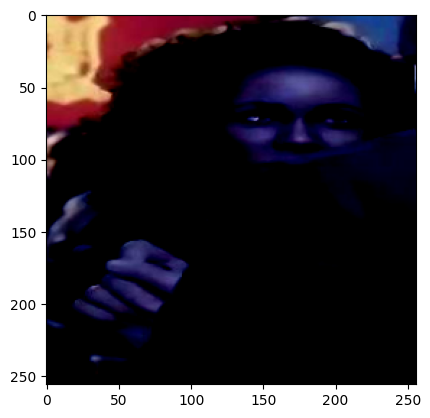

In [98]:
plt.imshow(test_img.permute(1, 2, 0))

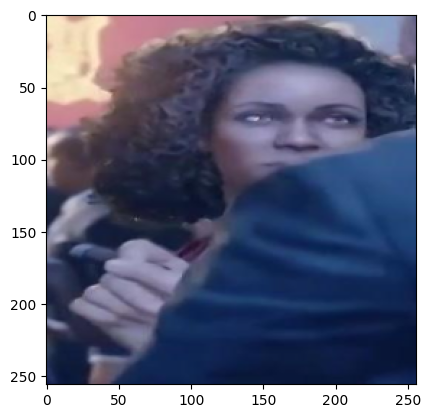

In [99]:
plt.imshow(revert_normalisation(test_img))

### Training

In [100]:
batch_size = 1
epochs = 100
lambda_weight = 5
lambda_idt_X = 0.5
lambda_idt_Y = 0.5

blocks = 6
upsample_strategy = ["upsample", "conv_transpose", "pixel_shuffle"][0]
pool_size = 20
opt_scheduler_type = "linear_decay_with_warmup"

checkpoint_instance_dir = None
checkpoint_epoch_dir = None

In [101]:
dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
)

In [102]:
if checkpoint_instance_dir is not None and checkpoint_epoch_dir is not None:
    cyclegan = RecycleGAN.load(f"{run_data_directory}/{checkpoint_instance_dir}", f"{checkpoint_epoch_dir}", device, blocks)
else:
    cyclegan = RecycleGAN(blocks, upsample_strategy, device, pool_size, opt_scheduler_type, epochs)

Save folder: ./runs/RecycleGAN/1681138017.3112457
Initialised weights


In [103]:
with open(f"{cyclegan.save_folder}/info_{checkpoint_epoch_dir}.json", "w+") as fp:
    json.dump({
        "block_count": cyclegan.resnet_block_count,
        "upsample_strategy": upsample_strategy,
        "pool_size": pool_size,
        "opt_scheduler_type": opt_scheduler_type,
        "data_folders": {
            "train_X": train_X_loc,
            "test_X": test_X_loc,
            "train_Y": train_Y_loc,
            "test_Y": test_Y_loc
        },
        "batch_size": batch_size,
        "max_epochs": epochs,
        "start_epoch": cyclegan.start_epoch,
        "lambda_weight": lambda_weight,
        "lambda_idt_X": lambda_idt_X,
        "lambda_idt_Y": lambda_idt_Y,
        "checkpoint": {
            "instance": checkpoint_instance_dir,
            "epoch": checkpoint_epoch_dir
        }
    }, fp, indent=2)

In [104]:
# Could also enable random flipping
def generate_noisy_labels(shape, real, device):
    # Randomly generated between 0 and 1
    labels = torch.rand(shape, device=device)
    
    if real:
        # Now they are between 0.7 and 1.1
        labels = (2 * labels / 5) + 0.7
    else:
        # Now they are between 0 and 0.3
        labels = (labels * 3) / 10
    
    return labels

In [105]:
def get_discriminator_loss(real, fake, pool, discriminator, loss_func):
    # Discriminator should give (1) for a real image and (0) for a fake
    real_pred = discriminator(real)
    real_loss = loss_func(real_pred, generate_noisy_labels(real_pred.shape, True, device)) # Should dampen?
    
    # We draw from the history buffer
    pool_fake = pool.randomise_existing_batch(fake)
    fake_pred = discriminator(pool_fake)
    # Fake images should not fool the discriminator
    fake_loss = loss_func(fake_pred.detach(), generate_noisy_labels(fake_pred.shape, False, device))
    
    avg_loss = (real_loss + fake_loss) * 0.5
    return avg_loss

In [106]:
if cyclegan.start_epoch != 0:
    print(f"Resuming training from epoch {cyclegan.start_epoch + 1}")
else:
    print("Starting training from scratch")

if vis is not None:
    loss_plot = MultiLinePlot(vis, "Losses", "Epoch", "Loss")

for epoch in range(cyclegan.start_epoch + 1, epochs + 1):
    cyclegan.G.train()
    cyclegan.F.train()
    
    cyclegan.D_X.train()
    cyclegan.D_Y.train()
    
    cyclegan.P_X.train()
    cyclegan.P_Y.train()

    batch_start_time = time.time()
    epoch_start_time = time.time()
    
    cum_loss_idt_x = 0
    cum_loss_idt_y = 0
    cum_G_fool_loss = 0
    cum_F_fool_loss = 0
    cum_predictor_x_loss = 0
    cum_predictor_y_loss = 0
    cum_cycled_x_loss = 0
    cum_cycled_y_loss = 0
    cum_D_X_loss = 0
    cum_D_Y_loss = 0
    
    ep_loss_idt_x = 0
    ep_loss_idt_y = 0
    ep_G_fool_loss = 0
    ep_F_fool_loss = 0
    ep_predictor_x_loss = 0
    ep_predictor_y_loss = 0
    ep_cycled_x_loss = 0
    ep_cycled_y_loss = 0
    ep_D_X_loss = 0
    ep_D_Y_loss = 0
    
    for batch_no, ((x_0, x_1, x_2), (y_0, y_1, y_2)) in enumerate(dataloader):
        # Load the sequence of frames to the GPU
        x_0 = x_0.to(device)
        x_1 = x_1.to(device)
        x_2 = x_2.to(device)
        
        y_0 = y_0.to(device)
        y_1 = y_1.to(device)
        y_2 = y_2.to(device)
        
        # Firstly, generate fake images in domain Y using the x_t images
        fake_y_0 = cyclegan.G(x_0)
        fake_y_1 = cyclegan.G(x_1)
        
        # For the final frame we use the predictor model, we are doing this in domain Y space so use P_Y not P_X
        fake_y_2 = cyclegan.P_Y(torch.cat((fake_y_0, fake_y_1), 1))
        
        # Then generate the fake images in domain X using the y_t images
        fake_x_0 = cyclegan.F(y_0)
        fake_x_1 = cyclegan.F(y_1)
        # For the final frame we use the predictor model, we are doing this in domain X space so use P_X not P_Y
        fake_x_2 = cyclegan.P_X(torch.cat((fake_x_0, fake_x_1), 1))
        
        ### GENERATOR TRAINING
        
        # Freeze discriminator weights
        for param in cyclegan.D_X.parameters():
            param.requires_grad = False

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = False
        
        # Zero the gradients for the generators and predictors
        cyclegan.G_opt.zero_grad()
        cyclegan.F_opt.zero_grad()
        cyclegan.P_X_opt.zero_grad()
        cyclegan.P_Y_opt.zero_grad()
        
        # Calculate the identity loss, this tries to enforce that G(y) = I(y) = y i.e. the identity
        idt_x_0 = cyclegan.F(x_0)
        idt_x_1 = cyclegan.F(x_1)
        loss_idt_x = cyclegan.identity_loss(idt_x_0, x_0) + cyclegan.identity_loss(idt_x_1, x_1)
        
        idt_y_0 = cyclegan.G(y_0)
        idt_y_1 = cyclegan.G(y_1)
        loss_idt_y = cyclegan.identity_loss(idt_y_0, y_0) + cyclegan.identity_loss(idt_y_1, y_1)
        
        # Now we try and fool the discriminators
        # D_X tries to tell if an image is from X (1) or from F(Y) (0) so it takes input fake_x_t
        # D_X is supposed to be 1 if the image is from X but here we are trying to get it to be 1 if it is from G(X) -> Y which is incorrect
        G_fool_0 = cyclegan.D_Y(fake_y_0) 
        # We want to tell if fake_y_0 has fooled D_X, so we measure how far from the output 1 it is 
        G_fool_loss_0 = cyclegan.gan_loss(G_fool_0, generate_noisy_labels(G_fool_0.shape, True, device))
        
        G_fool_1 = cyclegan.D_Y(fake_y_1)
        G_fool_loss_1 = cyclegan.gan_loss(G_fool_1, generate_noisy_labels(G_fool_1.shape, True, device))
        
        G_fool_2 = cyclegan.D_Y(fake_y_2)
        G_fool_loss_2 = cyclegan.gan_loss(G_fool_2, generate_noisy_labels(G_fool_2.shape, True, device))
        
        G_fool_loss = G_fool_loss_0 + G_fool_loss_1 + G_fool_loss_2
        
        # D_Y tries to tell if an image is from Y (1) or from G(X) (0) so it takes input fake_y_t
        F_fool_0 = cyclegan.D_X(fake_x_0)
        # We want to tell if fake_x_0 has fooled D_Y, so we measure how far from the output 1 it is 
        F_fool_loss_0 = cyclegan.gan_loss(F_fool_0, generate_noisy_labels(F_fool_0.shape, True, device))
        
        F_fool_1 = cyclegan.D_X(fake_x_1)
        F_fool_loss_1 = cyclegan.gan_loss(F_fool_1, generate_noisy_labels(F_fool_1.shape, True, device))
        
        F_fool_2 = cyclegan.D_X(fake_x_2)
        F_fool_loss_2 = cyclegan.gan_loss(F_fool_2, generate_noisy_labels(F_fool_2.shape, True, device))
        
        F_fool_loss = F_fool_loss_0 + F_fool_loss_1 + F_fool_loss_2
        
        # Now we train the predictors on the real images using the recurrent loss
        # x_2 first
        predicted_x_2 = cyclegan.P_X(torch.cat((x_0, x_1), 1))
        predicted_x_loss = cyclegan.recurrent_loss(predicted_x_2, x_2)
        
        # So recycled_x_2 = F(P_Y(G(x_0), G(x_1)))
        recycled_x_2 = cyclegan.F(fake_y_2)
        recycled_x_loss = cyclegan.recycle_loss(recycled_x_2, x_2)
        
        predictor_x_loss = predicted_x_loss + recycled_x_loss
        
        # now y_2
        predicted_y_2 = cyclegan.P_Y(torch.cat((y_0, y_1), 1))
        predicted_y_loss = cyclegan.recurrent_loss(predicted_y_2, y_2)
        
        # So recycled_y_2 = G(P_X(F(y_0), F(y_1)))
        recycled_y_2 = cyclegan.G(fake_x_2)
        recycled_y_loss = cyclegan.recycle_loss(recycled_y_2, y_2)
        
        predictor_y_loss = predicted_y_loss + recycled_y_loss
        
        # Now do the cycle loss
        cycled_x_0 = cyclegan.F(fake_y_0)
        cycled_loss_x_0 = cyclegan.cycle_loss(cycled_x_0, x_0)
        
        cycled_x_1 = cyclegan.F(fake_y_1)
        cycled_loss_x_1 = cyclegan.cycle_loss(cycled_x_1, x_1)
        
        cycled_loss_x = cycled_loss_x_0 + cycled_loss_x_1
        
        cycled_y_0 = cyclegan.G(fake_x_0)
        cycled_loss_y_0 = cyclegan.cycle_loss(cycled_y_0, y_0)
        
        cycled_y_1 = cyclegan.G(fake_x_1)
        cycled_loss_y_1 = cyclegan.cycle_loss(cycled_y_1, y_1)
        
        cycled_loss_y = cycled_loss_y_0 + cycled_loss_y_1
        
        # Backpropagate and step the gradients
        generator_loss = G_fool_loss + F_fool_loss + lambda_weight * (cycled_loss_x + cycled_loss_y + predictor_x_loss + predictor_y_loss + lambda_idt_X * loss_idt_x + lambda_idt_Y * loss_idt_y)
        generator_loss.backward()
        
        cyclegan.G_opt.step()
        cyclegan.F_opt.step()
        cyclegan.P_X_opt.step()
        cyclegan.P_Y_opt.step()
        
        del G_fool_0
        del G_fool_1
        del G_fool_2
        del F_fool_0
        del F_fool_1
        del F_fool_2
        
        ### DISCRIMINATOR TRAINING
        # Unfreeze discriminator weights
        for param in cyclegan.D_X.parameters():
            param.requires_grad = True

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = True
        
        # Zero the gradients
        cyclegan.D_X_opt.zero_grad()
        cyclegan.D_Y_opt.zero_grad()
        
        D_X_loss_0 = get_discriminator_loss(x_0, fake_x_0, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss_1 = get_discriminator_loss(x_1, fake_x_1, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss_fake_pred = get_discriminator_loss(x_2, fake_x_2, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss_real_pred = get_discriminator_loss(x_2, predicted_x_2, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss = D_X_loss_0 + D_X_loss_1 + D_X_loss_fake_pred + D_X_loss_real_pred
        
        D_Y_loss_0 = get_discriminator_loss(y_0, fake_y_0, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss_1 = get_discriminator_loss(y_1, fake_y_1, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss_fake_pred = get_discriminator_loss(y_2, fake_y_2, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss_real_pred = get_discriminator_loss(y_2, predicted_y_2, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss = D_Y_loss_0 + D_Y_loss_1 + D_Y_loss_fake_pred + D_Y_loss_real_pred
        
        # Backpropagate and step the gradients
        D_loss = D_X_loss + D_Y_loss
        D_loss.backward()
        
        cyclegan.D_X_opt.step()
        cyclegan.D_Y_opt.step()
        
        ### UPDATE POOLS
        cyclegan.fake_X_buffer.add(fake_x_0.detach())
        cyclegan.fake_X_buffer.add(fake_x_1.detach())
        cyclegan.fake_X_buffer.add(fake_x_2.detach())
        
        cyclegan.fake_Y_buffer.add(fake_y_0.detach())
        cyclegan.fake_Y_buffer.add(fake_y_1.detach())
        cyclegan.fake_Y_buffer.add(fake_y_2.detach())
        
        ### TRACK LOSS
        cum_loss_idt_x += loss_idt_x.item()
        cum_loss_idt_y += loss_idt_y.item()
        cum_G_fool_loss += G_fool_loss.item()
        cum_F_fool_loss += F_fool_loss.item()
        cum_predictor_x_loss += predictor_x_loss.item()
        cum_predictor_y_loss += predictor_y_loss.item()
        cum_cycled_x_loss += cycled_loss_x.item()
        cum_cycled_y_loss += cycled_loss_y.item()
        cum_D_X_loss += D_X_loss.item()
        cum_D_Y_loss += D_Y_loss.item()
        
        ep_loss_idt_x += loss_idt_x.item()
        ep_loss_idt_y += loss_idt_y.item()
        ep_G_fool_loss += G_fool_loss.item()
        ep_F_fool_loss += F_fool_loss.item()
        ep_predictor_x_loss += predictor_x_loss.item()
        ep_predictor_y_loss += predictor_y_loss.item()
        ep_cycled_x_loss += cycled_loss_x.item()
        ep_cycled_y_loss += cycled_loss_y.item()
        ep_D_X_loss += D_X_loss.item()
        ep_D_Y_loss += D_Y_loss.item()
        
        if epoch == 0 and batch_no < 55:
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
        
        if batch_no % 100 == 0 and batch_no != 0: 
            duration = time.time() - batch_start_time
            
            updated_losses = {
                "loss_idt_x": cum_loss_idt_x / 100,
                "loss_idt_y": cum_loss_idt_y / 100,
                "G_fool_loss": cum_G_fool_loss / 100,
                "F_fool_loss": cum_F_fool_loss / 100,
                "predictor_x_loss": cum_predictor_x_loss / 100,
                "predictor_y_loss": cum_predictor_y_loss / 100,
                "cycled_x_loss": cum_cycled_x_loss / 100,
                "cycled_y_loss": cum_cycled_y_loss / 100,
                "D_X_loss": cum_D_X_loss / 100,
                "D_Y_loss": cum_D_Y_loss / 100
            }
            
            x_loss_str = f"[{epoch}:{batch_no}]"
            y_loss_str = f"[{epoch}:{batch_no}]"
            
            for i, (key, value) in enumerate(updated_losses.items()):
                if i % 2 == 0:
                    x_loss_str = f"{x_loss_str} {key}: {value},"
                else:
                    y_loss_str = f"{y_loss_str} {key}: {value},"
            
            x_loss_str = x_loss_str[:-1]
            y_loss_str = y_loss_str[:-1]

            print(f"[{epoch}:{batch_no}] Took {duration:.2f}s")
            print(x_loss_str)
            print(y_loss_str)
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
            
            if vis is not None:
                loss_plot.append_values(epoch + batch_no / len(dataloader), updated_losses)
            
            cum_loss_idt_x = 0
            cum_loss_idt_y = 0
            cum_G_fool_loss = 0
            cum_F_fool_loss = 0
            cum_predictor_x_loss = 0
            cum_predictor_y_loss = 0
            cum_cycled_x_loss = 0
            cum_cycled_y_loss = 0
            cum_D_X_loss = 0
            cum_D_Y_loss = 0

            batch_start_time = time.time()
    
    print(f"[{epoch}:END] Completed epoch in {time.time() - epoch_start_time}s")
    
    print(f"[{epoch}:{batch_no}]", 
          f"ep_loss_idt_x: {ep_loss_idt_x / len(dataloader):.3f}", 
          f"ep_G_fool_loss: {ep_G_fool_loss / len(dataloader):.3f}", 
          f"ep_predictor_x_loss: {ep_predictor_x_loss / len(dataloader):.3f}", 
          f"ep_cycled_x_loss: {ep_cycled_x_loss / len(dataloader):.3f}",
          f"ep_D_X_loss: {ep_D_X_loss / len(dataloader):.3f}")
    
    print(f"[{epoch}:{batch_no}]", 
          f"ep_loss_idt_y: {ep_loss_idt_y / len(dataloader):.3f}", 
          f"ep_F_fool_loss: {ep_F_fool_loss / len(dataloader):.3f}", 
          f"ep_predictor_y_loss: {ep_predictor_y_loss / len(dataloader):.3f}", 
          f"ep_cycled_y_loss: {ep_cycled_y_loss / len(dataloader):.3f}",
          f"ep_D_Y_loss: {ep_D_Y_loss / len(dataloader):.3f}")
    
    cyclegan.G.eval()
    cyclegan.F.eval()
    
    if vis is not None:
        eval_start_time = time.time()

        G_eval_forward = cyclegan.apply(test_xs, x_to_y=True)
        F_eval_forward = cyclegan.apply(test_ys, x_to_y=False)

        G_rev = cyclegan.apply(G_eval_forward, x_to_y=False)
        F_rev = cyclegan.apply(F_eval_forward, x_to_y=True)

        G_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_eval_forward])
        F_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_eval_forward])
        G_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_rev])
        F_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_rev])

        G_eval_grid = torchvision.utils.make_grid(G_eval_forward, nrow=4)
        F_eval_grid = torchvision.utils.make_grid(F_eval_forward, nrow=4)
        G_rev_grid = torchvision.utils.make_grid(G_rev, nrow=4)
        F_rev_grid = torchvision.utils.make_grid(F_rev, nrow=4)
        
        folder = f"{cyclegan.save_folder}/{epoch}"
        os.makedirs(folder, exist_ok=True)
        
        torchvision.utils.save_image(G_eval_grid, f"{folder}/X_to_Y.png")
        torchvision.utils.save_image(F_eval_grid, f"{folder}/Y_to_X.png")
        torchvision.utils.save_image(G_rev_grid, f"{folder}/X_to_Y_to_X.png")
        torchvision.utils.save_image(F_rev_grid, f"{folder}/Y_to_X_to_Y.png")

        vis.image(G_eval_grid, win="G_eval", opts={
            "caption": f"X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_eval_grid, win="F_eval", opts={
            "caption": f"Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(G_rev_grid, win="G_rev", opts={
            "caption": f"X -> Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_rev_grid, win="F_rev", opts={
            "caption": f"Y -> X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })
        
        print(f"[{epoch}:END] Completed eval in {time.time() - eval_start_time}s")

    cyclegan.G.train()
    cyclegan.F.train()

    cyclegan.step_learning_rates()

    if epoch % 5 == 0 or epoch == 1:
        print(f"[{epoch}:END] Saving models and training information permanently")
        cyclegan.save(epoch, full_save=True)
        cyclegan.save(epoch, full_save=True, folder="latest")
    else:
        print(f"[{epoch}:END] Saving models and training information temporarily to latest and saving generators permanently")
        cyclegan.save(epoch, full_save=True, folder="latest")
        cyclegan.save(epoch, full_save=False)

Starting training from scratch
[1:100] Took 128.80s
[1:100] loss_idt_x: 0.5541572569310665, G_fool_loss: 1.2144887962937354, predictor_x_loss: 0.5378934526443482, cycled_x_loss: 0.5712447628378868, D_X_loss: 2.9364376056194303
[1:100] loss_idt_y: 0.5900187434256077, F_fool_loss: 1.1524032039940357, predictor_y_loss: 0.6516065680980683, cycled_y_loss: 0.6338832598924636, D_Y_loss: 2.9707430136203765
[1:100] fake_X_buffer: 20, fake_Y_buffer: 20
[1:200] Took 115.73s
[1:200] loss_idt_x: 0.4161659163236618, G_fool_loss: 0.24905044183135033, predictor_x_loss: 0.3754124814271927, cycled_x_loss: 0.43967310324311254, D_X_loss: 1.4462473320960998
[1:200] loss_idt_y: 0.4895300783216953, F_fool_loss: 0.2763815892487764, predictor_y_loss: 0.4596289026737213, cycled_y_loss: 0.5378765086829662, D_Y_loss: 1.3951566183567048
[1:200] fake_X_buffer: 20, fake_Y_buffer: 20
[1:300] Took 115.53s
[1:300] loss_idt_x: 0.42299161195755003, G_fool_loss: 0.16848139703273773, predictor_x_loss: 0.35075939163565634, 

### Video Style Transfer

In [107]:
model_time = "1680898964.0020654"
model_parent_directory = f"./runs/RecycleGAN/{model_time}"
epoch_directory = "latest"
model_name = "F.pth" # F: Y -> X which is the style transfer we want

In [108]:
with open(f"{model_parent_directory}/info_None.json", "r") as fp:
    model_info = json.load(fp)

upsample_strategy = model_info["upsample_strategy"]
block_count = model_info["block_count"]

In [109]:
model = Generator(block_count, upsample_strategy).to(device)
model.load_state_dict(torch.load(f"{model_parent_directory}/{epoch_directory}/{model_name}"))

<All keys matched successfully>

In [110]:
input_video_path = "./original_data/Test/Test Movie.mp4"
output_video_path = f"./video_transfer/recyclegan_{model_time}.mp4"
batch_size = 4

os.makedirs("./video_transfer", exist_ok=True)

In [111]:
process_video(input_video_path, output_video_path, model, batch_size=batch_size)

  0%|          | 0/1645 [00:00<?, ?it/s]

### Frame Comparison

To run this you may need to rename the 'Test Movie.mp4' to 'test_movie.mp4' to avoid issues with whitespace!

In [112]:
%%bash
./video_transfer_frame_comparison.sh "./original_data/Test/test_movie.mp4" "./video_transfer/cyclegan_1680981254.7780375.mp4" "./video_transfer/recyclegan_1680898964.0020654.mp4"

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

### Evaluation

#### Segmentation Maps

I begin by cycling the images:

In [113]:
base_transfer_folder = "./extracted_data/recyclegan_transferred"
test_input_folder = lambda base: f"./extracted_data/recyclegan_training_data/{base}/Test"

model_parent_folder = "./runs/RecycleGAN/1680898964.0020654"
game_to_movie_path = f"{model_parent_folder}/latest/G.pth"
movie_to_game_path = f"{model_parent_folder}/latest/F.pth"

batch_size = 1

In [114]:
with open(f"{model_parent_folder}/info_None.json", "r") as fp:
    model_info = json.load(fp)

upsample_strategy = model_info["upsample_strategy"]
block_count = model_info["block_count"]

for base in ["Game", "Movie"]:
    other_domain = "Movie" if base == "Game" else "Game"
    model_path =  game_to_movie_path if base == "Game" else movie_to_game_path
    test_folder = test_input_folder(base)
    transferred_folder = f"{base_transfer_folder}/{base}_to_{other_domain}"
    
    os.makedirs(transferred_folder)
    
    model = Generator(block_count, upsample_strategy).to(device)
    model.load_state_dict(torch.load(model_path))
    
    file_names = [file_name for file_name in os.listdir(test_folder) if file_name.endswith(".jpg")]
    batch_count = len(file_names) // batch_size + 1
    
    for batch_no in tqdm(range(batch_count)):
        selected_files = []
        
        for i in range(batch_size):
            real_i = batch_size * batch_no + i
            
            if real_i >= len(file_names):
                break
            
            selected_files.append(file_names[real_i])
        
        if len(selected_files) == 0:
            break
            
        batch_images = [cv2.cvtColor(cv2.imread(f"{test_folder}/{file_name}"), cv2.COLOR_BGR2RGB) for file_name in selected_files]
        transferred = transfer_style_to_batch(batch_images, model)
        
        for file_name, transferred_image in zip(selected_files, transferred):
            cv2.imwrite(f"{transferred_folder}/{''.join(file_name.split('.')[:-1])}_transferred.jpg", cv2.cvtColor((transferred_image.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

In [115]:
with open(f"{model_parent_folder}/info_None.json", "r") as fp:
    model_info = json.load(fp)

upsample_strategy = model_info["upsample_strategy"]
block_count = model_info["block_count"]

for base in ["Game", "Movie"]:
    other_domain = "Movie" if base == "Game" else "Game"
    model_path =  movie_to_game_path if base == "Game" else game_to_movie_path
    test_folder = f"{base_transfer_folder}/{base}_to_{other_domain}"
    transferred_folder = f"{base_transfer_folder}/{base}_to_{other_domain}_to_{base}"
    
    os.makedirs(transferred_folder)
    
    model = Generator(block_count, upsample_strategy).to(device)
    model.load_state_dict(torch.load(model_path))
    
    file_names = [file_name for file_name in os.listdir(test_folder) if file_name.endswith(".jpg")]
    batch_count = len(file_names) // batch_size + 1
    
    for batch_no in tqdm(range(batch_count)):
        selected_files = []
        
        for i in range(batch_size):
            real_i = batch_size * batch_no + i
            
            if real_i >= len(file_names):
                break
            
            selected_files.append(file_names[real_i])
        
        if len(selected_files) == 0:
            break
            
        batch_images = [cv2.cvtColor(cv2.imread(f"{test_folder}/{file_name}"), cv2.COLOR_BGR2RGB) for file_name in selected_files]
        transferred = transfer_style_to_batch(batch_images, model)
        
        for file_name, transferred_image in zip(selected_files, transferred):
            cv2.imwrite(f"{transferred_folder}/{''.join(file_name.split('.')[:-1])}_transferred.jpg", cv2.cvtColor((transferred_image.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

In [116]:
original_game_folder = "./extracted_data/recyclegan_training_data/Game/Test"
cycled_game_folder = "./extracted_data/recyclegan_transferred/Game_to_Movie_to_Game"
original_game_files = [f"{original_game_folder}/{file_name}" for file_name in os.listdir(original_game_folder) if file_name.endswith(".jpg")]
cycled_game_files = [f"{cycled_game_folder}/{file_name}" for file_name in os.listdir(cycled_game_folder) if file_name.endswith(".jpg")]

original_movie_folder = "./extracted_data/recyclegan_training_data/Movie/Test"
cycled_movie_folder = "./extracted_data/recyclegan_transferred/Movie_to_Game_to_Movie"
original_movie_files = [f"{original_movie_folder}/{file_name}" for file_name in os.listdir(original_movie_folder) if file_name.endswith(".jpg")]
cycled_movie_files = [f"{cycled_movie_folder}/{file_name}" for file_name in os.listdir(cycled_movie_folder) if file_name.endswith(".jpg")]

threshold = 0.9

In [117]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")
maskrcnn.to(device).eval()
;

''

In [118]:
# The 91 COCO class names, directly from Semantic Segmentation Mask R-CNN.ipynb
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [119]:
def retrieve_segmentation_map(output, frame, threshold):
    # Get the relevant model output on to the CPU in a usable format
    scores = output["scores"].detach().cpu().numpy()
    boxes = output["boxes"].detach().cpu().numpy().astype(int)
    label_indices = output["labels"].detach().cpu()
    masks = (output["masks"] > 0.5).detach().cpu()
    
    segmentation_maps = {label: np.zeros(frame.shape[:2]).astype(np.uint8) for label in coco_names[1:]}
    
    # Process each entry found by the model
    for i, (confidence, box, label_idx, mask) in enumerate(zip(scores, boxes, label_indices, masks)):
        label = coco_names[label_idx.item()]
        
        # The confidences are sorted high to low so stop once we're below the threshold
        if confidence < threshold:
            break
        
        segmentation_maps[label][(mask == 1).squeeze()] = 1
    
    return segmentation_maps

In [120]:
def measure_segmentation_map_similarity(original_files, cycled_files):
    tensor_transform = transforms.Compose([transforms.ToTensor()])
    mean_accuracies = []
    
    for original_file_name, cycled_file_name in tqdm(zip(original_files, cycled_files), total=len(original_files)):
        original_file = cv2.imread(original_file_name, cv2.IMREAD_COLOR)
        cycled_file = cv2.imread(cycled_file_name, cv2.IMREAD_COLOR)
        
        if original_file.shape != cycled_file.shape:
            original_file = cv2.cvtColor(original_file, cv2.COLOR_BGR2RGB)
            original_file_pil = Image.fromarray(original_file).resize((256, 256))
            original_file = np.asarray(original_file_pil)
            original_file = cv2.cvtColor(original_file, cv2.COLOR_RGB2BGR)
            
            cycled_file = cv2.cvtColor(cycled_file, cv2.COLOR_BGR2RGB)
            cycled_file_pil = Image.fromarray(cycled_file).resize((256, 256))
            cycled_file = np.asarray(cycled_file_pil)
            cycled_file = cv2.cvtColor(cycled_file, cv2.COLOR_RGB2BGR)
            
        
        maskrcnn_batch = torch.stack([tensor_transform(original_file), tensor_transform(cycled_file)]).to(device)
        
        with torch.no_grad():
            outputs = maskrcnn(maskrcnn_batch)
            
        original_seg_maps = retrieve_segmentation_map(outputs[0], original_file, threshold)
        cycled_seg_maps = retrieve_segmentation_map(outputs[1], cycled_file, threshold)
        
        ins_accuracies = []
        
        for label in coco_names[1:]:
            original_seg_map = original_seg_maps[label]
            cycled_seg_map = cycled_seg_maps[label]
            
            assert original_seg_map.shape == cycled_seg_map.shape
            
            if not original_seg_map.any() and not cycled_seg_map.any():
                continue
            
            correct_pixels = ((original_seg_map == 1) & (cycled_seg_map == 1)).sum()
            total_pixels = (original_seg_map == 1).sum()
            
#             dupe_frame = original_file.copy()
#             y = np.stack([original_seg_map, original_seg_map, original_seg_map], axis=2).astype(np.uint8)
#             cv2.addWeighted(dupe_frame, 1.0, y * 200, 0.6, 0.0, dupe_frame)
#             cv2.imwrite(f"./test_{time.time()}_{label}_org.png", dupe_frame)
            
#             dupe_frame = cycled_file.copy()
#             y = np.stack([cycled_seg_map, cycled_seg_map, cycled_seg_map], axis=2).astype(np.uint8)
#             cv2.addWeighted(dupe_frame, 1.0, y * 200, 0.6, 0.0, dupe_frame)
#             cv2.imwrite(f"./test_{time.time()}_{label}_cycled.png", dupe_frame)
            
            if total_pixels == 0:
                continue
    
            accuracy = correct_pixels / total_pixels
            ins_accuracies.append(accuracy)
            
        if len(ins_accuracies) == 0:
            continue
        
        mean_accuracy = sum(ins_accuracies) / len(ins_accuracies)
        mean_accuracies.append(mean_accuracy)
    
    return sum(mean_accuracies) / len(mean_accuracies)

In [121]:
game_fcn = measure_segmentation_map_similarity(original_game_files, cycled_game_files)

  0%|          | 0/245 [00:00<?, ?it/s]

In [122]:
game_fcn

0.7096492848913747

In [123]:
movie_fcn = measure_segmentation_map_similarity(original_movie_files, cycled_movie_files)

  0%|          | 0/235 [00:00<?, ?it/s]

In [124]:
movie_fcn

0.5468722320982466

#### FID and KID

In [125]:
score = fid.compute_fid(test_input_folder("Movie"), "./extracted_data/recyclegan_transferred/Game_to_Movie", num_workers=0)

compute FID between two folders
Found 470 images in the folder ./extracted_data/recyclegan_training_data/Movie/Test



FID Test : 100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.28it/s]


Found 490 images in the folder ./extracted_data/recyclegan_transferred/Game_to_Movie



FID Game_to_Movie : 100%|██████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


In [126]:
score

172.33488812395717

In [127]:
score = fid.compute_kid(test_input_folder("Movie"), "./extracted_data/recyclegan_transferred/Game_to_Movie", num_workers=0)

compute KID between two folders
Found 470 images in the folder ./extracted_data/recyclegan_training_data/Movie/Test



KID Test : 100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.30it/s]


Found 490 images in the folder ./extracted_data/recyclegan_transferred/Game_to_Movie



KID Game_to_Movie : 100%|██████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


In [128]:
score

0.04133906387394656

In [129]:
score = fid.compute_fid(test_input_folder("Game"), "./extracted_data/recyclegan_transferred/Movie_to_Game", num_workers=0)

compute FID between two folders
Found 490 images in the folder ./extracted_data/recyclegan_training_data/Game/Test



FID Test : 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


Found 470 images in the folder ./extracted_data/recyclegan_transferred/Movie_to_Game



FID Movie_to_Game : 100%|██████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.45it/s]


In [130]:
score

178.9576746667507

In [131]:
score = fid.compute_kid(test_input_folder("Game"), "./extracted_data/recyclegan_transferred/Movie_to_Game", num_workers=0)

compute KID between two folders
Found 490 images in the folder ./extracted_data/recyclegan_training_data/Game/Test



KID Test : 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Found 470 images in the folder ./extracted_data/recyclegan_transferred/Movie_to_Game



KID Movie_to_Game : 100%|██████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.55it/s]


In [132]:
score

0.04826035881512055